## Import the necessary libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import math

# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# For performance measure
from perf_measure import performance_metrics

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

## Data collection and preprocessing

In [35]:
test = yf.download('^VIX', start="2011-10-11", end="2020-04-01")[["Open","Close"]]
test.columns = [f"{ticker.lower()}_{pos.lower()}" for pos, ticker in test.columns]

[*********************100%***********************]  1 of 1 completed


In [36]:
test

,^vix_open,^vix_close
Date,,
2011-10-11 00:00:00+00:00,33.950001,32.860001
2011-10-12 00:00:00+00:00,31.570000,31.260000
2011-10-13 00:00:00+00:00,31.990000,30.700001
2011-10-14 00:00:00+00:00,29.070000,28.240000
2011-10-17 00:00:00+00:00,30.350000,33.389999
...,...,...
2020-03-25 00:00:00+00:00,61.439999,63.950001
2020-03-26 00:00:00+00:00,65.669998,61.000000
2020-03-27 00:00:00+00:00,64.949997,65.540001


In [3]:
# tickers to be used in research
tickers = ['^VIX', 'VIXY', 'SVXY', 'SPY']

In [6]:
# collecting the data into a df
stock_data = pd.DataFrame()

for ticker in tickers:
    if ticker == '^VIX':
        vix = yf.download(ticker, start="2011-10-11", end="2020-04-01")["Open"]
        vix.columns = ["vix_spot_open"]
        stock_data = vix

    else:
        tmp = yf.download(ticker, start="2011-10-11", end="2020-04-01")[["Open","Close"]]
        tmp.columns = [f"{ticker.lower()}_open", f"{ticker.lower()}_close"]
        stock_data = stock_data.join(tmp)

stock_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vix_spot_open,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close
Date,,,,,,,
2011-10-11 00:00:00+00:00,33.950001,202360.0,197540.0,12.0625,12.3150,118.870003,119.699997
2011-10-12 00:00:00+00:00,31.570000,190320.0,184200.0,12.7900,13.1725,120.599998,120.750000
2011-10-13 00:00:00+00:00,31.990000,186400.0,183840.0,13.0000,13.0675,120.040001,120.510002
2011-10-14 00:00:00+00:00,29.070000,175860.0,173140.0,13.8475,13.9375,121.910004,122.570000
2011-10-17 00:00:00+00:00,30.350000,174000.0,191440.0,13.7250,12.4050,121.989998,120.230003


In [10]:
stock_data.index.dtype

datetime64[ns, UTC]

In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2131 entries, 2011-10-11 00:00:00+00:00 to 2020-03-31 00:00:00+00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vix_spot_open  2131 non-null   float64
 1   vixy_open      2131 non-null   float64
 2   vixy_close     2131 non-null   float64
 3   svxy_open      2131 non-null   float64
 4   svxy_close     2131 non-null   float64
 5   spy_open       2131 non-null   float64
 6   spy_close      2131 non-null   float64
dtypes: float64(7)
memory usage: 197.7 KB


In [57]:
# no library to get futures data - had to download csv file from investing.com
vix_future = pd.read_csv("S&P 500 VIX Futures Historical Data.csv", usecols=['Date','Open'],parse_dates=['Date']).sort_values(by='Date', ascending=True).set_index('Date')
vix_future.rename(columns={"Open":"vx_open"}, inplace=True)
vix_future.head()

,vx_open
Date,
2011-10-11,34.67
2011-10-12,34.47
2011-10-13,32.80
2011-10-14,31.13
2011-10-17,29.42


In [11]:
vix_future.index.dtype

dtype('<M8[ns]')

In [13]:
vix_future.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2209 entries, 2011-10-11 to 2020-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     2209 non-null   float64
 1   Open      2209 non-null   float64
 2   High      2209 non-null   float64
 3   Low       2209 non-null   float64
 4   Vol.      1969 non-null   object 
 5   Change %  2209 non-null   object 
dtypes: float64(4), object(2)
memory usage: 120.8+ KB


In [8]:
# now to bring both raw dfs together before starting feature engineering
data = stock_data.join(vix_future['Open'])
data.rename(columns={'Open':'vix_future_open'}, inplace=True)
data.head()

TypeError: Cannot join tz-naive with tz-aware DatetimeIndex

In [ ]:
data.

### If basis is negative then term structure is backwardation. If basis is positive, then term structure is contango.

In [6]:
# calculating basis - to determine contango and backwardation
data['basis'] = data.apply(lambda x: (x['vix_future_open'] / x['vix_spot_open']) - 1, axis=1)
#data['basis_signals'] = data['basis'].apply(lambda x: -1 if x < 0 else 1)
data.head(20)

,vix_spot_open,vixy_open,vixy_close,svxy_open,svxy_close,spy_open,spy_close,vix_future_open,basis
Date,,,,,,,,,
2011-10-11,33.950001,202360.0,197540.0,24.125000,24.629999,118.870003,119.699997,34.67,0.021208
2011-10-12,31.570000,190320.0,184200.0,25.580000,26.344999,120.599998,120.750000,34.47,0.091859
2011-10-13,31.990000,186400.0,183840.0,26.000000,26.135000,120.040001,120.510002,32.80,0.025320
2011-10-14,29.070000,175860.0,173140.0,27.695000,27.875000,121.910004,122.570000,31.13,0.070863
2011-10-17,30.350000,174000.0,191440.0,27.450001,24.809999,121.989998,120.230003,29.42,-0.030643
2011-10-18,33.369999,191620.0,183880.0,24.750000,25.670000,120.139999,122.580002,33.35,-0.000599
2011-10-19,32.919998,182960.0,196420.0,25.889999,23.959999,122.379997,121.129997,31.08,-0.055893
2011-10-20,34.439999,197720.0,198300.0,23.825001,23.754999,121.430000,121.660004,32.97,-0.042683
2011-10-21,32.759998,190920.0,187460.0,24.639999,24.924999,123.089996,123.970001,33.97,0.036935


## Strategy 1: Long Short VIX (LSV)

In [16]:
def lsv_strategy(df: pd.DataFrame(), initial_capital: float) -> pd.DataFrame():
    tmp = df.copy()

    vixy_buy_signal = []
    svxy_buy_signal = []
    vixy_sell_signal = []
    svxy_sell_signal = []
    vixy_long_position = False
    svxy_long_position = False

    for i in range(len(tmp)):
        if tmp['basis'][i] < 0:
            if vixy_long_position == False:
                if svxy_long_position == False:
                    vixy_buy_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    vixy_long_position = True
                else:
                    svxy_sell_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    vixy_long_position = True
                    svxy_long_position = False
            else:
                svxy_sell_signal.append(np.nan)
                vixy_buy_signal.append(np.nan)
                svxy_buy_signal.append(np.nan)
                vixy_sell_signal.append(np.nan)
        else:
            if svxy_long_position == False:
                if vixy_long_position == False:
                    svxy_buy_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(np.nan)
                    vixy_sell_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    svxy_long_position = True
                else:
                    vixy_sell_signal.append(tmp['vixy_open'][i])
                    svxy_buy_signal.append(tmp['svxy_open'][i])
                    vixy_buy_signal.append(np.nan)
                    svxy_sell_signal.append(np.nan)
                    vixy_long_position = False
                    svxy_long_position = True
            else:
                svxy_sell_signal.append(np.nan)
                vixy_buy_signal.append(np.nan)
                svxy_buy_signal.append(np.nan)
                vixy_sell_signal.append(np.nan)

    res = pd.DataFrame(index=tmp.index)
    res[["vixy_buy_signal_price","svxy_buy_signal_price","vixy_sell_signal_price",
        "svxy_sell_signal_price"]] = pd.Series([vixy_buy_signal, svxy_buy_signal, vixy_sell_signal, svxy_sell_signal])

    available_cash = []
    max_holding_for_the_day = []
    max_holding_asset_for_the_day = []
    sale_proceeds = 0.00

    for each_day in range(len(res)):
        if available_cash:
            if not np.isnan(res['vixy_buy_signal_price'][each_day]) and not np.isnan(res['svxy_sell_signal_price'][each_day]):
                sale_proceeds += max_holding_for_the_day[each_day - 1] *  res['svxy_sell_signal_price'][each_day]
                max_holding_for_the_day.append(math.floor((available_cash[each_day - 1] + sale_proceeds) / res['vixy_buy_signal_price'][each_day]))
                available_cash.append((available_cash[each_day - 1] + sale_proceeds) - \
                                        (max_holding_for_the_day[each_day] * res['vixy_buy_signal_price'][each_day]))
                max_holding_asset_for_the_day.append("vixy")
                sale_proceeds = 0.00

            elif not np.isnan(res['svxy_buy_signal_price'][each_day]) and not np.isnan(res['vixy_sell_signal_price'][each_day]):
                sale_proceeds += max_holding_for_the_day[each_day - 1] *  res['vixy_sell_signal_price'][each_day]
                max_holding_for_the_day.append(math.floor((available_cash[each_day - 1] + sale_proceeds) / res['svxy_buy_signal_price'][each_day]))
                available_cash.append((available_cash[each_day - 1] + sale_proceeds) - \
                                        (max_holding_for_the_day[each_day] * res['svxy_buy_signal_price'][each_day]))
                max_holding_asset_for_the_day.append("svxy")
                sale_proceeds = 0.00

            else:
                available_cash.append(available_cash[each_day - 1])
                max_holding_for_the_day.append(max_holding_for_the_day[each_day - 1])
                max_holding_asset_for_the_day.append(max_holding_asset_for_the_day[each_day - 1])
        else:
            max_holding_for_the_day.append(math.floor(initial_capital / res['svxy_buy_signal_price'][each_day]))
            available_cash.append(initial_capital - ((math.floor(initial_capital / res['svxy_buy_signal_price'][each_day]))\
                                                      * res['svxy_buy_signal_price'][each_day]))
            max_holding_asset_for_the_day.append("svxy")

    
    res[["max_holding_for_the_day","max_holding_asset_for_the_day","available_cash"]] = pd.Series([max_holding_for_the_day,
                                                                                                    max_holding_asset_for_the_day,
                                                                                                      available_cash])
    
    res[["vixy_close","svxy_close"]] = tmp[["vixy_close","svxy_close"]]

    res["portfolio_value"] = res.apply(lambda x : ((x["vixy_close"] * x["max_holding_for_the_day"]) + x["available_cash"]) \
                                       if (x["max_holding_asset_for_the_day"] == "vixy") else \
                                        ((x["svxy_close"] * x["max_holding_for_the_day"]) + x["available_cash"]), axis=1)
    
    res["portfolio_returns"] = res["portfolio_value"].pct_change()
    res["portfolio_cumulative_returns"] = (1 + res["portfolio_returns"]).cumprod() - 1

    return res

lsv = lsv_strategy(data, 100000)
lsv.head(20)

,vixy_buy_signal_price,svxy_buy_signal_price,vixy_sell_signal_price,svxy_sell_signal_price,max_holding_for_the_day,max_holding_asset_for_the_day,available_cash,vixy_close,svxy_close,portfolio_value,portfolio_returns,portfolio_cumulative_returns
Date,,,,,,,,,,,,
2011-10-11,NaN,24.125000,NaN,NaN,4145,svxy,1.875000,197540.0,24.629999,102093.221521,NaN,NaN
2011-10-12,NaN,NaN,NaN,NaN,4145,svxy,1.875000,184200.0,26.344999,109201.897154,0.069629,0.069629
2011-10-13,NaN,NaN,NaN,NaN,4145,svxy,1.875000,183840.0,26.135000,108331.450949,-0.007971,0.061103
2011-10-14,NaN,NaN,NaN,NaN,4145,svxy,1.875000,173140.0,27.875000,115543.750000,0.066576,0.131748
2011-10-17,174000.0,NaN,NaN,27.450001,0,vixy,113782.128162,191440.0,24.809999,113782.128162,-0.015246,0.114492
2011-10-18,NaN,NaN,NaN,NaN,0,vixy,113782.128162,183880.0,25.670000,113782.128162,0.000000,0.114492
2011-10-19,NaN,NaN,NaN,NaN,0,vixy,113782.128162,196420.0,23.959999,113782.128162,0.000000,0.114492
2011-10-20,NaN,NaN,NaN,NaN,0,vixy,113782.128162,198300.0,23.754999,113782.128162,0.000000,0.114492
2011-10-21,NaN,24.639999,190920.0,NaN,4617,svxy,19.250980,187460.0,24.924999,115097.972458,0.011565,0.127381


In [8]:
lsv_perf = performance_metrics(lsv, "portfolio_value", "Date")
lsv_perf.GeR_metric()

0.5874824384577124

<AxesSubplot: xlabel='Date'>

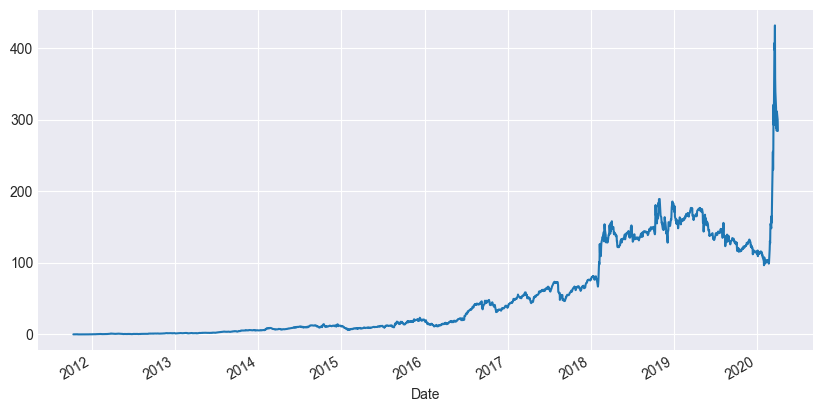

In [9]:
lsv["portfolio_cumulative_returns"].plot(figsize=(10,5))

## Strategy 2: Hedged Long Short VIX (HLSV) 

In [13]:
def hlsv_strategy(df: pd.DataFrame()) -> pd.DataFrame():
    tmp = df.copy()

    vixy_open_long_price = []
    vixy_close_long_price = []

    svxy_open_long_price = []
    svxy_close_long_price = []

    spy_open_long_price = []
    spy_close_long_price = []
    spy_open_short_price = []
    spy_close_short_price = []

    vixy_long_position = False
    svxy_long_position = False
    spy_long_position = False
    spy_short_position = False

    for i in range(len(tmp)):
        # If basis is negative
        if tmp['basis'][i] < 0:
            if vixy_long_position == False and spy_long_position == False:
                if svxy_long_position == False and spy_short_position == False:
                    vixy_open_long_price.append(tmp['vixy_open'][i])
                    spy_open_long_price.append(tmp['spy_open'][i])

                    vixy_close_long_price.append(np.nan)
                    svxy_open_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                    spy_open_short_price.append(np.nan)
                    spy_close_short_price.append(np.nan)

                    vixy_long_position = True
                    spy_long_position = True

                else:
                    svxy_close_long_price.append(tmp['svxy_open'][i])
                    spy_close_short_price.append(tmp['spy_open'][i])  # this is to close spy short position

                    svxy_long_position = False
                    spy_short_position = False

                    vixy_open_long_price.append(tmp['vixy_open'][i])
                    spy_open_long_price.append(tmp['spy_open'][i])
                
                    vixy_long_position = True
                    spy_long_position = True

                    svxy_open_long_price.append(np.nan)
                    vixy_close_long_price.append(np.nan)
                    spy_open_short_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                
            else:
                vixy_open_long_price.append(np.nan)
                vixy_close_long_price.append(np.nan)
                svxy_open_long_price.append(np.nan)
                svxy_close_long_price.append(np.nan)
                spy_open_long_price.append(np.nan)
                spy_close_long_price.append(np.nan)
                spy_open_short_price.append(np.nan)
                spy_close_short_price.append(np.nan)
        # if the basis is positive      
        else:
            if svxy_long_position == False and spy_short_position == False:
                if vixy_long_position == False and spy_long_position == False:
                    svxy_open_long_price.append(tmp['svxy_open'][i])
                    spy_open_short_price.append(tmp['spy_open'][i])   # this is to open a short position in SPY

                    svxy_long_position = True
                    spy_short_position = True

                    vixy_open_long_price.append(np.nan)
                    vixy_close_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_open_long_price.append(np.nan)
                    spy_close_long_price.append(np.nan)
                    spy_close_short_price.append(np.nan)
                
                else:
                    vixy_close_long_price.append(tmp['vixy_open'][i])
                    spy_close_long_price.append(tmp['spy_open'][i])  # this is to close long position in SPY

                    vixy_long_position = False
                    spy_long_position = False

                    svxy_open_long_price.append(tmp['svxy_open'][i])
                    spy_open_short_price.append(tmp['spy_open'][i])   # this is to open a short position in SPY

                    svxy_long_position = True
                    spy_short_position = True

                    vixy_open_long_price.append(np.nan)
                    svxy_close_long_price.append(np.nan)
                    spy_open_long_price.append(np.nan)
                    spy_close_short_price.append(np.nan)

            else:
                vixy_open_long_price.append(np.nan)
                vixy_close_long_price.append(np.nan)
                svxy_open_long_price.append(np.nan)
                svxy_close_long_price.append(np.nan)
                spy_open_long_price.append(np.nan)
                spy_close_long_price.append(np.nan)
                spy_open_short_price.append(np.nan)
                spy_close_short_price.append(np.nan)

    res = pd.DataFrame(index=tmp.index)
    
    res[["vixy_open_long_price","vixy_close_long_price","svxy_open_long_price","svxy_close_long_price",
        "spy_open_long_price","spy_close_long_price","spy_open_short_price","spy_close_short_price"]
        ] = pd.Series([vixy_open_long_price, vixy_close_long_price, svxy_open_long_price,\
            svxy_close_long_price,spy_open_long_price,spy_close_long_price,spy_open_short_price,spy_close_short_price])
    
    return res

hlsv = hlsv_strategy(data)

In [17]:
hlsv

,vixy_open_long_price,vixy_close_long_price,svxy_open_long_price,svxy_close_long_price,spy_open_long_price,spy_close_long_price,spy_open_short_price,spy_close_short_price
Date,,,,,,,,
2011-10-11,NaN,NaN,24.125,NaN,NaN,NaN,118.870003,NaN
2011-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-17,174000.0,NaN,NaN,27.450001,121.989998,NaN,NaN,121.989998
...,...,...,...,...,...,...,...,...
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
